In [1]:
import torch
from torchvision import datasets, transforms
import random

In [2]:
# Path to your dataset
dataset_path = r'C:\Users\dzmit\Downloads\cat_images\cats_128x128'

In [3]:
# import os
# import shutil
# 
# # Path to the dataset directory you care about
# dataset_path = r'C:\Users\dzmit\Downloads\Imageandvideodataset\image dataset\train\2'
# 
# # New subfolder path for the single class
# subfolder_path = os.path.join(dataset_path, "class1")
# 
# # Create the subfolder if it does not exist
# if not os.path.exists(subfolder_path):
#     os.makedirs(subfolder_path)
# 
# # Move all files into the subfolder
# for file in os.listdir(dataset_path):
#     file_path = os.path.join(dataset_path, file)
#     if os.path.isfile(file_path):
#         shutil.move(file_path, subfolder_path)
# 
# print("All files moved to:", subfolder_path)

In [3]:
from torchvision import transforms

transform = transforms.Compose([
    # transforms.Resize((128, 128)),  # Resize all images to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Create the dataset
# dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [4]:
# DataLoader
batch_size = 24  # Batch size
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
import torch
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose2d(128, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input)


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input).view(-1, 1).squeeze(1)


# Device

In [7]:
# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [8]:
torch.cuda.is_available()

True

# Load the model

In [20]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [21]:
# discriminator(torch.randn(1, 3, 128, 128, device=device))

# Optimizers

In [30]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# Load the checkpoint

In [23]:
# checkpoint = torch.load('GAN_cat_299.pth')
# 
# # Assuming the generator and discriminator are already instantiated as per the saved model architecture
# generator.load_state_dict(checkpoint['generator_state_dict'])
# discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
# 
# # Assuming the optimizers are already instantiated with the parameters of their respective models
# optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
# optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
# 
# # If you saved the epoch number, you can also load this to know where to resume training
# epoch = checkpoint['epoch']


In [24]:
# for param_group in optimizer_G.param_groups:
#     param_group['lr'] *= 0.1
# 
# for param_group in optimizer_D.param_groups:
#     param_group['lr'] *= 0.1

# Plotting functions

In [36]:
import matplotlib.pyplot as plt

def generate_and_plot_images(n_images=9, epoch=0, plot=True, postfix='train'):
    """
    Generates and plots a grid of images using a trained generator model.

    Parameters:
    - generator: The trained generator model for generating images.
    - device: The device (e.g., 'cuda' or 'cpu') the model should run on.
    - n_images: The total number of images to generate and plot. Default is 9.
    """
    fig, axes = plt.subplots(5, 5, figsize=(9, 9))  # Create a 3x3 grid of subplots
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    for i in range(n_images):
        # Generate random noise
        noise = torch.randn(1, 100, 1, 1, device=device) / 100

        # Generate an image without updating gradients
        with torch.no_grad():
            generated_image = generator(noise)

        # Process the image for visualization
        generated_image = generated_image.to('cpu').clone().detach()
        generated_image = generated_image.numpy().squeeze(0)

        if generated_image.shape[0] == 3:  # Check if the image has 3 channels (RGB)
            generated_image = generated_image.transpose(1, 2, 0)  # Convert from CxHxW to HxWxC
            
        elif generated_image.shape[0] == 1:  # Check if the image has 3 channels (RGB)
            generated_image = generated_image.squeeze(0)  # Convert from CxHxW to HxWxC

        # Normalize the image data to [0, 1]
        generated_image = (generated_image + 1) / 2
        generated_image = generated_image.clip(0, 1)  # Ensure pixel values are within the expected range

        axes[i].imshow(generated_image, cmap='gray')
        axes[i].axis('off')  # Turn off the axis to make the images look cleaner

    plt.tight_layout()
    plt.savefig(f'output/{postfix}_generated_images_grid_{epoch}.png')

    if plot:
        plt.show()


In [27]:
# generate_and_plot_images(n_images=25, epoch=200)

# Clear cache

In [28]:
# import gc
# 
# torch.cuda.empty_cache()  # Clear cache
# gc.collect()  # Collect garbage
# generator.to('cpu')
# discriminator.to('cpu')
# 
# del generator, discriminator, optimizer_G, optimizer_D

In [29]:
num_epochs = 200
latent_size = 100

d_losses = []
g_losses = []

flip_prob = 0.1  # Probability of flipping labels

In [37]:
for epoch in range(18, num_epochs):
    try:
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            real_labels = torch.ones(real_images.size(0), device=device)
            fake_labels = torch.zeros(real_images.size(0), device=device)
        
            ### Train Discriminator
            optimizer_D.zero_grad()
            real_outputs = discriminator(real_images)
            d_loss_real = criterion(real_outputs, real_labels)
            d_loss_real.backward()
        
            noise = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = generator(noise)
            fake_outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(fake_outputs, fake_labels)
            d_loss_fake.backward()
            optimizer_D.step()
        
            ### Train Generator
            optimizer_G.zero_grad()
            # Optionally regenerate fake images for freshness
            noise = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = generator(noise)
            output = discriminator(fake_images)
        
            # Randomly decide whether to flip labels
            if random.random() < flip_prob:
                g_loss = criterion(output, fake_labels)  # Flipped labels
            else:
                g_loss = criterion(output, real_labels)  # Normal training
        
            g_loss.backward()
            optimizer_G.step()

    
            if (i + 1) % 20 == 0:
                d_losses.append(d_loss_real.item() + d_loss_fake.item())
                g_losses.append(g_loss.item())
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], '
                      f'D Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, '
                      f'G Loss: {g_loss.item():.4f}'
                      f'; D Loss Real: {d_loss_real.item():.4f}, '
                      f'; D Loss Fake: {d_loss_fake.item():.4f}, '
                      )
                
        if (epoch + 1) % 1 == 0:
            generator.eval()
            # check_output(fake_images[0], epoch)
            generate_and_plot_images(25, epoch=epoch, postfix='eval',plot=False)
            generator.train()
            generate_and_plot_images(25, epoch=epoch, postfix='train', plot=False)
            
        if (epoch + 1) % 30 == 0:
            checkpoint = {
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
                'epoch': epoch  # Optional, if you want to also save the epoch number
            }
            
            torch.save(checkpoint, f'GAN_cat_{epoch}.pth')

    except OSError:
        print(f"An error occurred while processing the image. Epoch: {epoch}, batch: {i}")
        continue


Epoch [19/200], Step [20/417], D Loss: 0.0418, G Loss: 5.6752; D Loss Real: 0.0353, ; D Loss Fake: 0.0065, 
Epoch [19/200], Step [40/417], D Loss: 1.2362, G Loss: 8.1593; D Loss Real: 0.0115, ; D Loss Fake: 1.2247, 
Epoch [19/200], Step [60/417], D Loss: 1.0919, G Loss: 0.1324; D Loss Real: 1.0664, ; D Loss Fake: 0.0254, 
Epoch [19/200], Step [80/417], D Loss: 0.4409, G Loss: 1.9319; D Loss Real: 0.3790, ; D Loss Fake: 0.0619, 
Epoch [19/200], Step [100/417], D Loss: 0.1738, G Loss: 4.7891; D Loss Real: 0.1022, ; D Loss Fake: 0.0715, 
Epoch [19/200], Step [120/417], D Loss: 0.2209, G Loss: 4.4602; D Loss Real: 0.0529, ; D Loss Fake: 0.1680, 
Epoch [19/200], Step [140/417], D Loss: 1.3087, G Loss: 4.8317; D Loss Real: 0.0121, ; D Loss Fake: 1.2966, 
Epoch [19/200], Step [160/417], D Loss: 1.0220, G Loss: 4.2835; D Loss Real: 0.0740, ; D Loss Fake: 0.9480, 
Epoch [19/200], Step [180/417], D Loss: 0.5255, G Loss: 3.9633; D Loss Real: 0.3502, ; D Loss Fake: 0.1752, 
Epoch [19/200], Step [2

C:\Users\dzmit\AppData\Local\Temp\ipykernel_15388\836817878.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(5, 5, figsize=(9, 9))  # Create a 3x3 grid of subplots


Epoch [30/200], Step [20/417], D Loss: 0.1197, G Loss: 6.9422; D Loss Real: 0.1183, ; D Loss Fake: 0.0014, 
Epoch [30/200], Step [40/417], D Loss: 0.5799, G Loss: 0.5556; D Loss Real: 0.4285, ; D Loss Fake: 0.1514, 
Epoch [30/200], Step [60/417], D Loss: 0.3696, G Loss: 5.5575; D Loss Real: 0.3617, ; D Loss Fake: 0.0079, 
Epoch [30/200], Step [80/417], D Loss: 0.4499, G Loss: 2.6738; D Loss Real: 0.0243, ; D Loss Fake: 0.4256, 
Epoch [30/200], Step [100/417], D Loss: 0.3690, G Loss: 0.0131; D Loss Real: 0.1042, ; D Loss Fake: 0.2648, 
Epoch [30/200], Step [120/417], D Loss: 0.2575, G Loss: 0.1526; D Loss Real: 0.1329, ; D Loss Fake: 0.1246, 
Epoch [30/200], Step [140/417], D Loss: 0.2738, G Loss: 3.0258; D Loss Real: 0.0336, ; D Loss Fake: 0.2403, 
Epoch [30/200], Step [160/417], D Loss: 0.2335, G Loss: 5.3044; D Loss Real: 0.1746, ; D Loss Fake: 0.0589, 
Epoch [30/200], Step [180/417], D Loss: 0.3306, G Loss: 0.0352; D Loss Real: 0.1563, ; D Loss Fake: 0.1743, 
Epoch [30/200], Step [2

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001B0B6695120> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [19]:
# Assuming 'generator' and 'discriminator' are your model instances
# And 'optimizer_G' and 'optimizer_D' are the optimizers for the generator and discriminator respectively

# Define checkpoint dictionary
checkpoint = {
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'epoch': epoch  # Optional, if you want to also save the epoch number
}

# Save checkpoint
torch.save(checkpoint, f'GAN_checkpoint_main_128_{epoch}.pth')


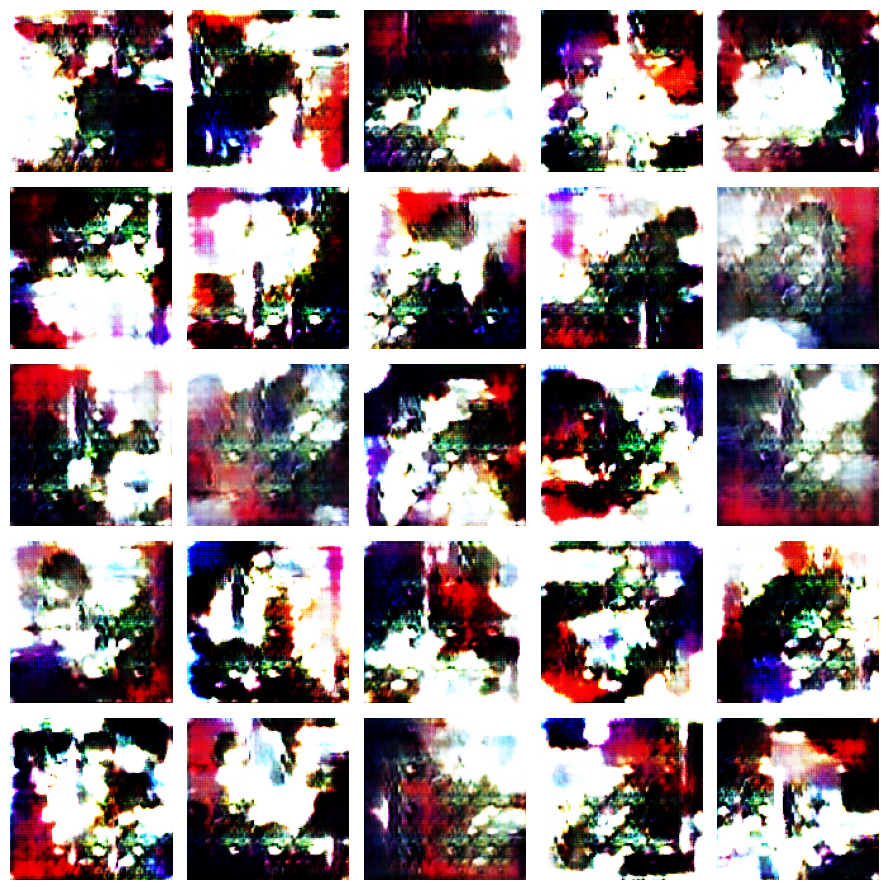

In [35]:
generate_and_plot_images(25, epoch=1000, plot=True)

In [ ]:
# check_output(real_images[-1])

In [ ]:
for i in range(1301, 1320):
    generate_and_plot_images(25, epoch=1301)

In [ ]:
# Generate random noise
noise = torch.randn(1, 100, 1, 1, device=device)  # Batch size of 1, latent vector size of 100

# Generate an image
with torch.no_grad():  # Temporarily set all the requires_grad flags to false
    generated_image = generator(noise)

In [ ]:

# generated_image = fake_images[23]

generated_image = generated_image.to('cpu').clone().detach()  # Move to CPU and detach from the computation graph
generated_image = generated_image.numpy()  # Convert to numpy array
generated_image = generated_image.squeeze(0)  # Remove the batch dimension, resulting in (channels, height, width)

# If the image is in the format (C, H, W), convert it to (H, W, C)
if generated_image.shape[0] == 3:  # Assuming 3 channels for RGB
    generated_image = generated_image.transpose(1, 2, 0)  # Reorder dimensions to (H, W, C)

# Normalize the image to [0, 1] if it's not already
generated_image = (generated_image + 1) / 2  # Assuming that the output is in the range [-1, 1]
generated_image = generated_image.clip(0, 1)  # Ensure the values are within [0, 1]


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(generated_image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


In [ ]:
for num, generated_image in enumerate(fake_images):
    # Generate random noise
    noise = torch.randn(1, 100, 1, 1, device=device) / 100  # Batch size of 1, latent vector size of 100
    
    # Generate an image
    with torch.no_grad():  # Temporarily set all the requires_grad flags to false
        generated_image = generator(noise)

    generated_image = generated_image.to('cpu').clone().detach()  # Move to CPU and detach from the computation graph
    generated_image = generated_image.numpy()  # Convert to numpy array
    generated_image = generated_image.squeeze(0)  # Remove the batch dimension, resulting in (channels, height, width)
    
    # If the image is in the format (C, H, W), convert it to (H, W, C)
    if generated_image.shape[0] == 3:  # Assuming 3 channels for RGB
        generated_image = generated_image.transpose(1, 2, 0)  # Reorder dimensions to (H, W, C)
    
    # Normalize the image to [0, 1] if it's not already
    generated_image = (generated_image + 1) / 2  # Assuming that the output is in the range [-1, 1]
    generated_image = generated_image.clip(0, 1)  # Ensure the values are within [0, 1]

    
    plt.imshow(generated_image)
    plt.savefig(f'output/generated_imag_{num}.png')


In [ ]:
for num, generated_image in enumerate(fake_images):

    generated_image = generated_image.to('cpu').clone().detach()  # Move to CPU and detach from the computation graph
    generated_image = generated_image.numpy()  # Convert to numpy array
    # generated_image = generated_image.squeeze(0)  # Remove the batch dimension, resulting in (channels, height, width)
    
    # If the image is in the format (C, H, W), convert it to (H, W, C)
    if generated_image.shape[0] == 3:  # Assuming 3 channels for RGB
        generated_image = generated_image.transpose(1, 2, 0)  # Reorder dimensions to (H, W, C)
    
    # Normalize the image to [0, 1] if it's not already
    generated_image = (generated_image + 1) / 2  # Assuming that the output is in the range [-1, 1]
    generated_image = generated_image.clip(0, 1)  # Ensure the values are within [0, 1]
    
    plt.imshow(generated_image)
    plt.savefig(f'output/fake_imag_{num}.png')


In [ ]:
for num, real_image in enumerate(real_images):

    real_image = real_image.to('cpu').clone().detach()  # Move to CPU and detach from the computation graph
    real_image = real_image.numpy()  # Convert to numpy array
    # generated_image = generated_image.squeeze(0)  # Remove the batch dimension, resulting in (channels, height, width)
    
    # If the image is in the format (C, H, W), convert it to (H, W, C)
    if real_image.shape[0] == 3:  # Assuming 3 channels for RGB
        real_image = real_image.transpose(1, 2, 0)  # Reorder dimensions to (H, W, C)
    
    # Normalize the image to [0, 1] if it's not already
    real_image = (real_image + 1) / 2  # Assuming that the output is in the range [-1, 1]
    real_image = real_image.clip(0, 1)  # Ensure the values are within [0, 1]
    
    plt.imshow(real_image)
    break
